In [354]:
# def nearest_node(point, coords):
#     """
#     Find the nearest node to a point and return the corresponding node label

#     ### Parameters
#     ----------
#     node : tuple
#         The coordinates of a point
#     coords : list
#         A list of coordinates of points

#     ### Returns
#     -------
#     tuple
#         The coordinates of the nearest node
#     """
#     dist = float("inf")
#     nearest_node = None
#     lat, long = point
#     for y, x, key in coords:
#         euclidean_distance = (lat - y) ** 2 + (long - x) ** 2
#         if euclidean_distance < dist:
#             dist = euclidean_distance
#             nearest_node = key
#     return nearest_node

In [1]:
from math import cos, asin, sqrt, pi


def distance(lat1, lon1, lat2, lon2):
    r = 6371
    p = pi / 180

    a = (
        0.5
        - cos((lat2 - lat1) * p) / 2
        + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    )
    return 2 * r * asin(sqrt(a)) * 100

In [2]:
from collections import defaultdict, deque
from heapq import heappop, heappush


class Graph:
    def __init__(self):
        self.graph = defaultdict(list)
        self.id_node = 0
        self.d = {}
        self.coords = {}

    def addEdge(self, u, v, w):
        self.graph[u].append((v, w))

    def get_id(self, x, y):
        if (x, y) not in self.d:
            self.d[(x, y)] = self.id_node
            self.id_node += 1
        self.coords[self.d[(x, y)]] = (x, y)
        return self.d[(x, y)]

    def add_nodes_between(self, density, threshold):
        for u in self.graph.copy():
            for v, w in self.graph[u].copy():
                if w < threshold:
                    continue
                x1, y1 = self.coords[u]
                x2, y2 = self.coords[v]
                delta_x = (x2 - x1) / (density + 1)
                delta_y = (y2 - y1) / (density + 1)
                start_id = self.get_id(x1, y1)
                end_id = self.get_id(x2, y2)
                for _ in range(density):
                    x1 += delta_x
                    y1 += delta_y
                    id = self.get_id(x1, y1)
                    self.addEdge(start_id, id, distance(y1, x1, y2, x2))
                    start_id = id
                self.addEdge(start_id, end_id, distance(y1, x1, y2, x2))

    def dijkstra(self, start, end):
        visited = defaultdict(bool)
        dist = defaultdict(lambda: float("inf"))
        trace = defaultdict(int)
        dist[start] = 0
        pq = [(0, start)]
        while pq:
            _, node = heappop(pq)
            if visited[node]:
                continue
            visited[node] = True
            if node == end:
                break
            for neighbor, weight in self.graph[node]:
                if dist[neighbor] > dist[node] + weight:
                    dist[neighbor] = dist[node] + weight
                    trace[neighbor] = node
                    heappush(pq, (dist[neighbor], neighbor))
        path = deque()
        while end != start:
            path.appendleft((self.coords[end][1], self.coords[end][0]))
            end = trace[end]
        path.appendleft((self.coords[start][1], self.coords[start][0]))
        return path

    def nearest_node(self, point):
        dist = float("inf")
        nearest_node_id = None
        lat, long = point
        for x, y in self.coords.values():
            d = distance(lat, long, y, x)
            if d < dist:
                dist = d
                nearest_node_id = self.d[(x, y)]
        return nearest_node_id

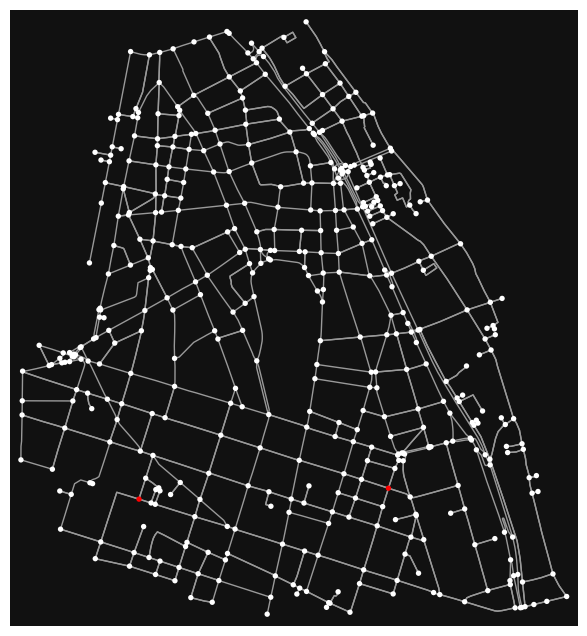

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
import random
import osmnx as ox

G = ox.graph_from_place("Hoàn Kiếm, Hà Nội, Vietnam", network_type="drive")

co = [(data["y"], data["x"]) for _, data in G.nodes(data=True)]


colors = ["w"] * len(co)

rd_node_1, rd_node_2 = random.choices(co, k=2)

colors[co.index(rd_node_1)] = "r"

colors[co.index(rd_node_2)] = "r"

# Display random point

ox.plot_graph(G, node_color=colors)

In [4]:
list(G.edges.data())[1]

(75617751,
 6644523689,
 {'osmid': 27933445,
  'lanes': '2',
  'name': 'Phố Hàng Khay',
  'highway': 'secondary',
  'oneway': False,
  'reversed': False,
  'length': 170.97699999999998,
  'geometry': <LINESTRING (105.853 21.025, 105.853 21.026, 105.852 21.026, 105.852 21.026)>})

In [8]:
g = Graph()

for u, v, geometry in list(G.edges.data("geometry")):
    if geometry:
        for i in range(len(geometry.coords) - 1):
            x1, y1 = geometry.coords[i]
            id_1 = g.get_id(x1, y1)
            x2, y2 = geometry.coords[i + 1]
            id_2 = g.get_id(x2, y2)
            g.addEdge(id_1, id_2, distance(y1, x1, y2, x2))
    else:
        x1, y1 = G.nodes[u]["x"], G.nodes[u]["y"]
        id_1 = g.get_id(x1, y1)
        x2, y2 = G.nodes[v]["x"], G.nodes[v]["y"]
        id_2 = g.get_id(x2, y2)
        g.addEdge(id_1, id_2, distance(y1, x1, y2, x2))

len(g.graph)

1856

In [11]:
len(g.graph), sum(len(v) for v in g.graph.values())

(13526, 15605)

In [10]:
g.add_nodes_between(15, 5)

In [412]:
import pickle

with open("graph.pkl", "wb") as f:
    pickle.dump(g, f)


In [390]:
coords = [(data["y"], data["x"], key) for key, data in G.nodes(data=True)]
# nr_start = nearest_node((start["lat"], start["lng"]), coords)
# nr_end = nearest_node((end["lat"], end["lng"]), coords)

In [403]:
g.nearest_node((21, 105.8532306))
g.coords[595]

(105.851603, 21.0182926)

In [413]:
(105.8532306, 21.025479) in g.coords.values()

True

In [393]:
with open("graph.pkl", "rb") as f:
    g_2 = pickle.load(f)

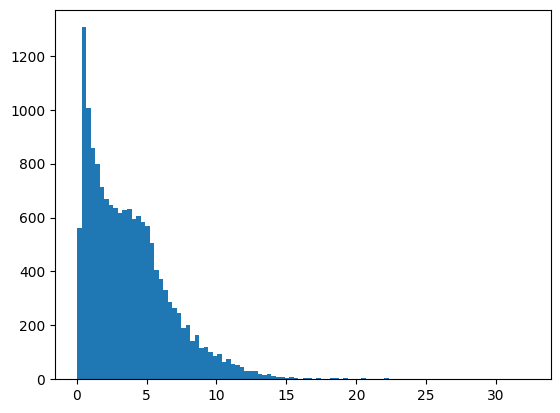

In [394]:
import numpy as np
import matplotlib.pyplot as plt
dists = np.concatenate([np.array([w for _, w in edge]) for edge in g.graph.values()])
# plot histogram of distances
plt.hist(dists, bins=100)
plt.show()

In [395]:
start = random.randint(0, 1000)
end = random.randint(0, 1000)
start, end

(453, 59)

In [404]:
path = g.dijkstra(start, end)
path

deque([(21.0260006, 105.8468693),
       (21.0259056, 105.8471788),
       (21.0258409, 105.8473988),
       (21.0260672, 105.8474754),
       (21.0263221, 105.8475605),
       (21.0264387, 105.8475957),
       (21.0269056, 105.847747),
       (21.0270442, 105.8477905),
       (21.0272231, 105.8478072),
       (21.0277929, 105.8478096),
       (21.0278636, 105.8478075),
       (21.0281196, 105.8477912),
       (21.0281712, 105.8479831),
       (21.0284076, 105.8482339),
       (21.0287347, 105.8485784),
       (21.0289725, 105.8490353),
       (21.0290028, 105.8490884),
       (21.0291799, 105.8494419),
       (21.0292347, 105.8494185),
       (21.0297634, 105.849188),
       (21.0305684, 105.8488561),
       (21.0309809, 105.8486867),
       (21.0310594, 105.8486543),
       (21.0311557, 105.8486114),
       (21.0321419, 105.8481641),
       (21.0323057, 105.8481005),
       (21.0324216, 105.8480556),
       (21.0324036, 105.8481944),
       (21.0323719, 105.8485186),
       (21.03240

In [397]:
rd_node_1 = (21.0216, 105.8414)

In [398]:
diff = 0
for i in range(1):
    # random_node_1 = (rd_node_1[0] + rand(), rd_node_1[1] + rand())
    # random_node_2 = (rd_node_2[0] + rand(), rd_node_2[1] + rand())
    nr_1 = ox.nearest_nodes(G, Y=rd_node_1[0], X=rd_node_1[1])
    print(G.nodes[nr_1])
#     if to_ll(nr_1) != nearest_node(random_node_1, co) or to_ll(nr_2) != nearest_node(
#         random_node_2, co
#     ):
#         diff += 1
# diff

{'y': 21.021558, 'x': 105.8430971, 'street_count': 3}
